In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Tue May 30 08:17:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!rm -r indonlu

rm: cannot remove 'indonlu': No such file or directory


In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git
!git clone https://github.com/fajri91/InSet.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 8.32 MiB/s, done.
Resolving deltas: 100% (229/229), done.
Cloning into 'InSet'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), 49.16 KiB | 1.97 MiB/s, done.


# 1. Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=cbe0427f031e390b1de826bb16ae20f16121a445b34d5d1ae79963e822774f29
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 M

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
nltk.download("stopwords")
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Exploratory Data Analysis

In [ ]:
df_path = 'sudahdisortir6k.txt'
stopword_path = 'stopword.txt'
kamus_alay_path = 'kamus_alay.csv'

In [ ]:
# Import data
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

In [ ]:
df

,review_text,category
0,"Aplikasi jeblok, gini hari masih bikin aplikas...",negative
1,Mohon dpt sgra diperbaiki krn pedulilindungi s...,negative
2,"Woi login jangan OTP via Whatsapp doang lah, k...",negative
3,"Tolong la Diperbaiki, banyak masyarakat yg tid...",negative
4,"! Bug. Bolak balik daftar pake email + hp, cum...",negative
...,...,...
5995,Aplikasinya sudah memuaskan,positif
5996,Semoga APK ini bs lebih baik lagi.,positif
5997,Aplikasi kok gini ya,positif
5998,Alhamdulillah sertifikat sudah keluar dua-duan...,positif


In [ ]:
print(f'shape: {df.shape}')

shape: (6000, 2)


## Proporsi Variabel Target

In [ ]:
df['category'].value_counts()

negative    2000
neutral     2000
positif     2000
Name: category, dtype: int64

In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None,colors=None, explode=None, shadow=None):

    # Plot
    ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%', 
           startangle = angle, pctdistance=0.8, explode = explode, 
           wedgeprops=dict(width=0.4), shadow=shadow)

    # Formatting
    plt.axis('equal')  
    plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['negative', 'positive', 'neutral']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

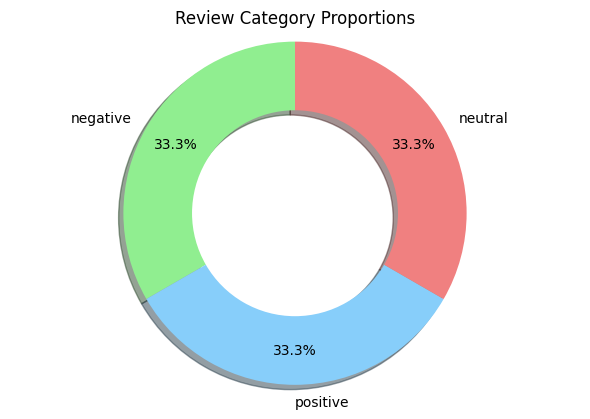

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [ ]:
import pandas as pd 
import numpy as np
df_path = 'sudahdisortir6k.txt'
Scrapped_Data = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

Scrapped_Data.head()

,review_text,category
0,"Aplikasi jeblok, gini hari masih bikin aplikas...",negative
1,Mohon dpt sgra diperbaiki krn pedulilindungi s...,negative
2,"Woi login jangan OTP via Whatsapp doang lah, k...",negative
3,"Tolong la Diperbaiki, banyak masyarakat yg tid...",negative
4,"! Bug. Bolak balik daftar pake email + hp, cum...",negative


In [ ]:

# ------ Case Folding --------
# gunakan fungsi Series.str.lower() pada Pandas
Scrapped_Data['review_text'] = Scrapped_Data['review_text'].str.lower()


print('Case Folding Result : \n')
print(Scrapped_Data['review_text'].head())
print('\n\n\n')

Case Folding Result : 

0    aplikasi jeblok, gini hari masih bikin aplikas...
1    mohon dpt sgra diperbaiki krn pedulilindungi s...
2    woi login jangan otp via whatsapp doang lah, k...
3    tolong la diperbaiki, banyak masyarakat yg tid...
4    ! bug. bolak balik daftar pake email + hp, cum...
Name: review_text, dtype: object






In [ ]:

import string 
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist

# ------ Tokenizing ---------

def remove_review_text_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_review_text_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_number)

#remove punctuation
def remove_punctuation(text):
    # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  return text

Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_whitespace_multiple)

# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

Scrapped_Data['review_text'] = Scrapped_Data['review_text'].apply(remove_singl_char)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

Scrapped_Data['review_text_tokens'] = Scrapped_Data['review_text'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(Scrapped_Data['review_text_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0    [aplikasi, jeblok, ,, gini, hari, masih, bikin...
1    [mohon, dpt, sgra, diperbaiki, krn, pedulilind...
2    [woi, login, jangan, otp, via, whatsapp, doang...
3    [tolong, la, diperbaiki, ,, banyak, masyarakat...
4    [!, bug, ., bolak, balik, daftar, pake, email,...
Name: review_text_tokens, dtype: object






In [ ]:
from nltk.corpus import stopwords

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')


# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo', 
                       'kalo', 'amp', 'biar', 'bikin', 'bilang', 
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih', 
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya', 
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't', 
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# ----------------------- add stopword from txt file ------------------------------------
# read txt stopword using pandas
txt_stopword = pd.read_csv("stopword.txt", names= ["stopwords"], header = None)

# convert stopword string to list & append additional stopword
list_stopwords.extend(txt_stopword["stopwords"][0].split(' '))

# ---------------------------------------------------------------------------------------

# convert list to dictionary
list_stopwords = set(list_stopwords)


#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

Scrapped_Data['review_text_tokens_WSW'] = Scrapped_Data['review_text_tokens'].apply(stopwords_removal) 


print(Scrapped_Data['review_text_tokens_WSW'].head())

0    [Aplikasi, jeblok, ,, gini, aplikasi, gampang,...
1    [Mohon, dpt, sgra, diperbaiki, pedulilindungi,...
2    [Woi, login, OTP, via, Whatsapp, doang, ,, kas...
3    [Tolong, la, Diperbaiki, ,, masyarakat, memaka...
4    [!, Bug, ., Bolak, daftar, pake, email, hp, ,,...
Name: review_text_tokens_WSW, dtype: object


In [ ]:
pip install Sastrawi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.1 MB/s eta 0:00:00
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16299 sha256=12d82e8442ed957845286dfd4be9530108faedf5cdb3b696e5c13ed43b8abe6f
  Stored in directory: /root/.cache/pip/wheels/6c/bd/3e/2d6afc9bc36c9975f8e4215a270bbac6580c4361ebd6bb2323
Successfully built swifter


In [ ]:

# import Sastrawi 
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter


# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in Scrapped_Data['review_text_tokens_WSW']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '
            
print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])
    
print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

Scrapped_Data['review_text_tokens_stemmed'] = Scrapped_Data['review_text_tokens_WSW'].swifter.apply(get_stemmed_term)
print(Scrapped_Data['review_text_tokens_stemmed'])

ModuleNotFoundError: ignored

In [ ]:
normalizad_word = pd.read_csv("kamus_alay.csv")

normalizad_word_dict = {}

for index, row in normalizad_word.iterrows():
    if row[0] not in normalizad_word_dict:
        normalizad_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalizad_word_dict[term] if term in normalizad_word_dict else term for term in document]

Scrapped_Data['review_text_normalized'] = Scrapped_Data['review_text_tokens_stemmed'].apply(normalized_term)

Scrapped_Data['review_text_normalized'].head(10)

0    [aplikasi, jeblok, , gin, aplikasi, gampang, e...
1    [mohon, dapat, sgra, baik, pedulilindungi, set...
2    [woi, login, otp, via, whatsapp, doang, , kasi...
3    [tolong, lah, baik, , masyarakat, pakai, whats...
4    [, bug, , bolak, daftar, pakai, email, handpho...
5    [busuk, aplikasi, , sudah, vaksin, aplikasi, k...
6    [sejak, baru, maret, aplikasi, pakai, , masuk,...
7    [sistem, buruk, , data, terinput, salah, , say...
8    [ini, aplikasi, baru, mudah, , bertambah, bert...
9    [buka, aplikasi, suruh, baru, , , bolak, , jug...
Name: review_text_normalized, dtype: object

In [ ]:
Scrapped_Data["review_text_normalizedjoin"] = [' '.join(word) for word in Scrapped_Data["review_text_normalized"]]

In [ ]:
# Memuat data positif dan negatif leksikon
file_read_p = pd.read_csv("/content/InSet/positive.tsv", sep='\t')
lexicon_positive = file_read_p.set_index('word').to_dict()['weight']

file_read_n = pd.read_csv("/content/InSet/negative.tsv", sep='\t')
lexicon_negative = file_read_n.set_index('word').to_dict()['weight']

In [ ]:
# Fungsi untuk menentukan polaritas sentimen 
def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
    polarity=''
    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity

results = Scrapped_Data['review_text_normalized'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
Scrapped_Data['polarity_score'] = results[0]
Scrapped_Data['polarity'] = results[1]
print(Scrapped_Data['polarity'].value_counts())
# Scrapped_Data.to_csv("/content/drive/MyDrive/Colab Notebooks/PREPRO6Kfinal_data.csv")

In [ ]:
Scrapped_Data.to_csv("filbert.csv",sep='\t', header=None, index=False)
#donwload trs dipake join sm polarity

In [ ]:
def make_corpus(column):
    
    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)     
        
    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one
        
    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df.review_text)

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 20415


In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples 
    
    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})
    
    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

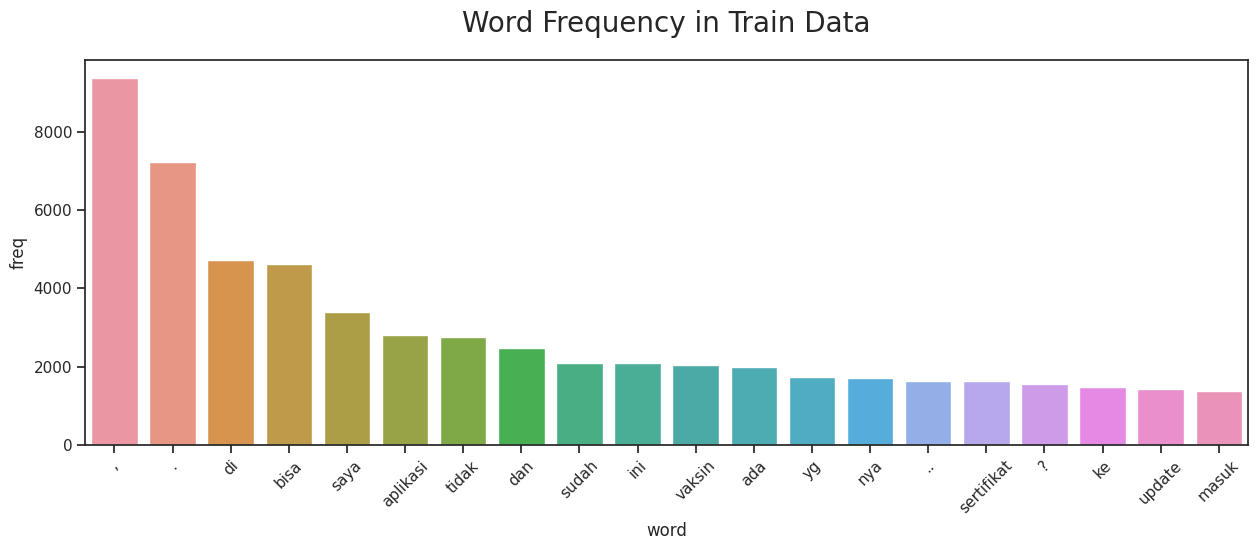

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

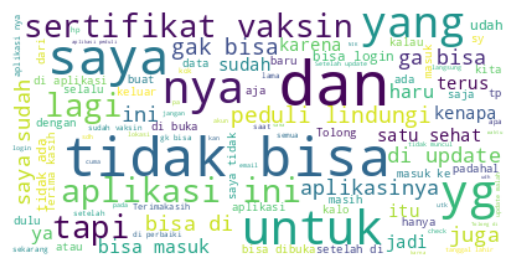

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [ ]:
import pandas as pd 
import numpy as np
df_path = 'filbert_filter.txt'
df = pd.read_csv(df_path, sep='\t', names=['review_text', 'category'])

df.head()

,review_text,category
0,aplikasi jeblok gin aplikasi gampang error a...,negative
1,mohon dapat sgra baik pedulilindungi setelah u...,negative
2,woi login otp via whatsapp doang kasih pilih ...,negative
3,tolong lah baik masyarakat pakai whatsapp ha...,negative
4,bug bolak daftar pakai email handphone samp...,negative


In [ ]:
# train val split
train_set, val_set = train_test_split(df, test_size=0.2, stratify=df.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.category, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (4800, 2)
Val shape: (804, 2)
Test shape: (396, 2)


In [ ]:
# export to tsv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

## b. Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
count_param(model)

124443651

## c. Prepare Dataset

In [ ]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

In [ ]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)  
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)  
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [ ]:
text = 'terbaik'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'''Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)
          {logits}''')

# int(torch.argmax(logits))+1

Text: terbaik | Label : positive (40.674%)
          tensor([[ 0.2750, -0.3824,  0.2134]], grad_fn=<AddmmBackward0>)


In [ ]:
text = 'susah login'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: susah login | Label : negative (42.846%)


In [ ]:
text = 'cukup baik'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: cukup baik | Label : negative (39.621%)


## e. Fine Tuning & Prediksi Evaluation

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)
 
    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    
    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)
    
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]        
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
        
        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))
        
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    
    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.6454 LR:0.00000300: 100%|██████████| 150/150 [00:43<00:00,  3.42it/s]


(Epoch 1) TRAIN LOSS:0.6454 ACC:0.76 F1:0.35 REC:0.37 PRE:0.60 LR:0.00000300


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.7480 ACC:0.72 F1:0.36 REC:0.39 PRE:0.36:   4%|▍         | 1/26 [00:01<00:35,  1.40s/it]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 1) VALID LOSS:0.6045 ACC:0.78 F1:0.42 REC:0.41 PRE:0.48


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 2) TRAIN LOSS:0.5081 LR:0.00000300: 100%|██████████| 150/150 [00:43<00:00,  3.43it/s]


(Epoch 2) TRAIN LOSS:0.5081 ACC:0.81 F1:0.54 REC:0.51 PRE:0.72 LR:0.00000300


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6653 ACC:0.75 F1:0.46 REC:0.48 PRE:0.44:   4%|▍         | 1/26 [00:00<00:24,  1.04it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 2) VALID LOSS:0.5123 ACC:0.82 F1:0.57 REC:0.54 PRE:0.80


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 3) TRAIN LOSS:0.4176 LR:0.00000300: 100%|██████████| 150/150 [00:44<00:00,  3.38it/s]


(Epoch 3) TRAIN LOSS:0.4176 ACC:0.85 F1:0.65 REC:0.60 PRE:0.81 LR:0.00000300


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.5894 ACC:0.81 F1:0.53 REC:0.60 PRE:0.49:   4%|▍         | 1/26 [00:00<00:20,  1.25it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 3) VALID LOSS:0.4771 ACC:0.83 F1:0.64 REC:0.61 PRE:0.77


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 4) TRAIN LOSS:0.3493 LR:0.00000300: 100%|██████████| 150/150 [00:43<00:00,  3.44it/s]


(Epoch 4) TRAIN LOSS:0.3493 ACC:0.87 F1:0.70 REC:0.66 PRE:0.81 LR:0.00000300


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6554 ACC:0.72 F1:0.41 REC:0.43 PRE:0.42:   4%|▍         | 1/26 [00:00<00:19,  1.26it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 4) VALID LOSS:0.5014 ACC:0.83 F1:0.63 REC:0.57 PRE:0.79


  0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
(Epoch 5) TRAIN LOSS:0.2796 LR:0.00000300: 100%|██████████| 150/150 [00:44<00:00,  3.39it/s]


(Epoch 5) TRAIN LOSS:0.2796 ACC:0.90 F1:0.74 REC:0.70 PRE:0.84 LR:0.00000300


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.5166 ACC:0.84 F1:0.58 REC:0.65 PRE:0.53:   4%|▍         | 1/26 [00:00<00:22,  1.12it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Undefi

(Epoch 5) VALID LOSS:0.4732 ACC:0.84 F1:0.66 REC:0.63 PRE:0.76


### Learning Curve

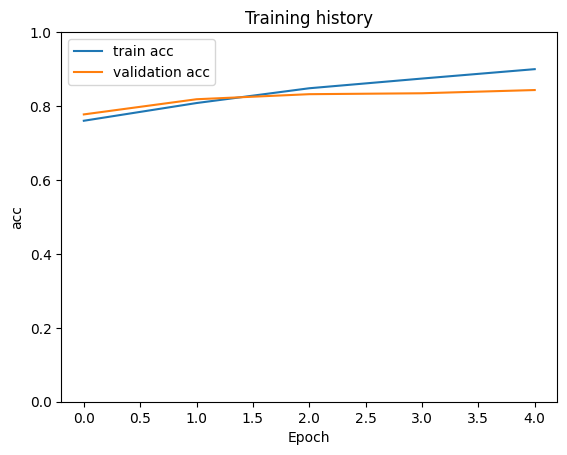

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['review_text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/13 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 13/13 [00:02<00:00,  5.76it/s]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['review_text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## e. Test fine-tuned model on sample sentences

In [ ]:
text = 'terbaik'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: terbaik | Label : neutral (47.372%)


In [ ]:
text = 'susah login'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: susah login | Label : negative (94.009%)


In [ ]:
text = 'cukup bagus'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: cukup bagus | Label : negative (89.263%)


# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

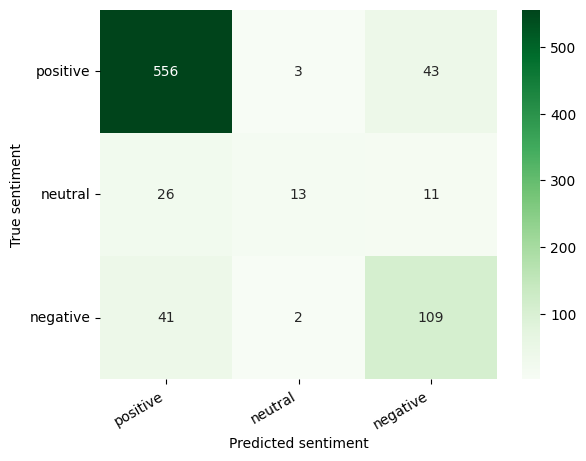

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.89      0.92      0.91       602
     neutral       0.72      0.26      0.38        50
    negative       0.67      0.72      0.69       152

    accuracy                           0.84       804
   macro avg       0.76      0.63      0.66       804
weighted avg       0.84      0.84      0.83       804



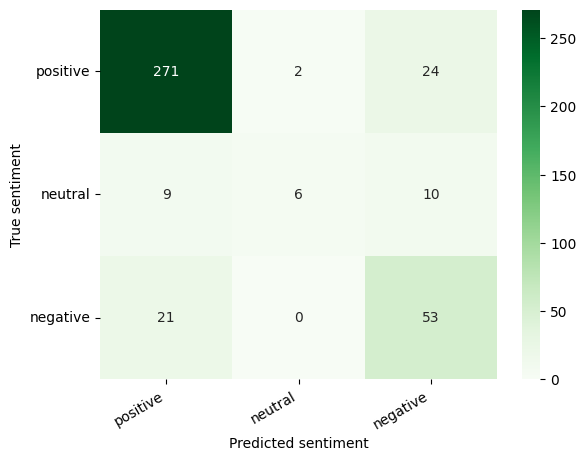

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Greens")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
  
cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.90      0.91      0.91       297
     neutral       0.75      0.24      0.36        25
    negative       0.61      0.72      0.66        74

    accuracy                           0.83       396
   macro avg       0.75      0.62      0.64       396
weighted avg       0.84      0.83      0.83       396

